In [1]:
from email import message_from_string
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import torch
import re

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./dataset/Processed_datasets/spamassassin_dataset.csv")

def extract_mail_components(text):
    try:
        msg = message_from_string(text)
        m_body = msg.get_payload()
        m_from = msg.get('From', '')
        m_return = msg.get('Return-Path', '')

        re_find = r'<([^>]*)>' 

        m_from = re.findall(re_find, m_from)[0] if re.findall(re_find, m_from) else ''
        m_return = re.findall(re_find, m_return)[0] if re.findall(re_find, m_return) else ''

        m_body = str(m_body)
        m_from = str(m_from)
        m_return = str(m_return)

        return m_body, m_from, m_return
    except Exception as e:
        print(f"Error processing text: {text[:100]}... Error: {e}")
        return '', '', ''  # Return empty values if there is an error processing the text

def extract_urls(text):
    import re
    url_list = []
    ipv4_pattern = r'(?:https?|ftp)?://(?:\d{1,3}\.){3}\d{1,3}(?::\d+)?(?:/\S*)?'
    url_pattern = (
        r'(?:(?:https?|ftp):\/\/)?'
        r'(?:[a-zA-Z0-9.%+-]+:[a-zA-Z0-9.%+-]+@)?'
        r'(?:www\.)?[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
        r'(?:\/\S*)?'
        r'|'
        + ipv4_pattern
    )
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'

    # Split the input string into words
    words = text.split()

    for word in words:
        if re.fullmatch(email_pattern, word):
            # Check if it also matches a URL and additional conditions
            if re.fullmatch(url_pattern, word):
                if word.count('@') > 1 or ":" in word.split('@')[-1]:
                    url_list.append(word)
        elif re.fullmatch(url_pattern, word):
            url_list.append(word)

    return url_list


df[['Body', 'From', 'Return-Path']] = df['Content'].apply(extract_mail_components).apply(pd.Series)
df['Urls'] = df['Body'].apply(extract_urls)


train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)



In [3]:

train_texts = train_data['Body'].tolist()
train_labels = train_data['Label'].tolist()

test_texts = test_data['Body'].tolist()
test_labels = test_data['Label'].tolist()

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)  # Adjust num_labels for your task

# Tokenize data
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = Dataset(train_encodings, train_labels)
test_dataset = Dataset(test_encodings, test_labels)

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=12,
    per_device_eval_batch_size=12,
    gradient_accumulation_steps=3,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2,
    fp16=True,  # Use mixed precision if using a GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

C:\Users\Asus\AppData\Local\Temp\ipykernel_11764\2162159181.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}










































































































































































































































                                        

                                           
  0%|          | 0/1401 [2:18:41<?, ?it/s]            



{'eval_loss': 0.07364913076162338, 'eval_runtime': 443.2109, 'eval_samples_per_second': 4.219, 'eval_steps_per_second': 0.528, 'epoch': 1.0}


C:\Users\Asus\AppData\Local\Temp\ipykernel_11764\2162159181.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                                          
  0%|          | 0/1401 [2:27:10<?, ?it/s]            

{'loss': 0.1432, 'grad_norm': 2.1398277282714844, 'learning_rate': 1.286224125624554e-05, 'epoch': 1.07}












































































































































































































































                                          
                                                   

  0%|          | 0/1401 [4:26:21<?, ?it/s]       



{'eval_loss': 0.0608011893928051, 'eval_runtime': 426.5539, 'eval_samples_per_second': 4.384, 'eval_steps_per_second': 0.549, 'epoch': 2.0}


C:\Users\Asus\AppData\Local\Temp\ipykernel_11764\2162159181.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
                                          
  0%|          | 0/1401 [4:43:29<?, ?it/s]             

{'loss': 0.0645, 'grad_norm': 2.924713134765625, 'learning_rate': 5.7244825124910784e-06, 'epoch': 2.14}


C:\Users\Asus\AppData\Local\Temp\ipykernel_11764\2162159181.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}










































































































































































































































                                          
                                                  

  0%|          | 0/1401 [6:36:18<?, ?it/s]       



{'eval_loss': 0.06217624619603157, 'eval_runtime': 438.6992, 'eval_samples_per_second': 4.263, 'eval_steps_per_second': 0.533, 'epoch': 3.0}


                                          
100%|██████████| 1401/1401 [6:35:26<00:00, 16.94s/it]

{'train_runtime': 23726.9779, 'train_samples_per_second': 0.946, 'train_steps_per_second': 0.059, 'train_loss': 0.0900027760431479, 'epoch': 3.0}


TrainOutput(global_step=1401, training_loss=0.0900027760431479, metrics={'train_runtime': 23726.9779, 'train_samples_per_second': 0.946, 'train_steps_per_second': 0.059, 'total_flos': 5896844972728320.0, 'train_loss': 0.0900027760431479, 'epoch': 2.9967914438502676})

In [7]:
# Predict on the test set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)
model.eval()
preds = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(model.device) for key, val in batch.items() if key != 'labels'}
        outputs = model(**inputs)
        preds.extend(torch.argmax(outputs.logits, axis=1).cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

# Evaluation metrics
print("Accuracy:", accuracy_score(true_labels, preds))
print("Classification Report:\n", classification_report(true_labels, preds))

C:\Users\Asus\AppData\Local\Temp\ipykernel_11764\2162159181.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.9705882352941176
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98      1366
           1       0.99      0.90      0.94       504

    accuracy                           0.97      1870
   macro avg       0.98      0.95      0.96      1870
weighted avg       0.97      0.97      0.97      1870



In [8]:
model.save_pretrained("saved_model_bodyOnly")
tokenizer.save_pretrained("saved_model_bodyOnly")

('saved_model_bodyOnly\\tokenizer_config.json',
 'saved_model_bodyOnly\\special_tokens_map.json',
 'saved_model_bodyOnly\\vocab.txt',
 'saved_model_bodyOnly\\added_tokens.json')

Confusion Matrix:
 [[1361    5]
 [  50  454]]


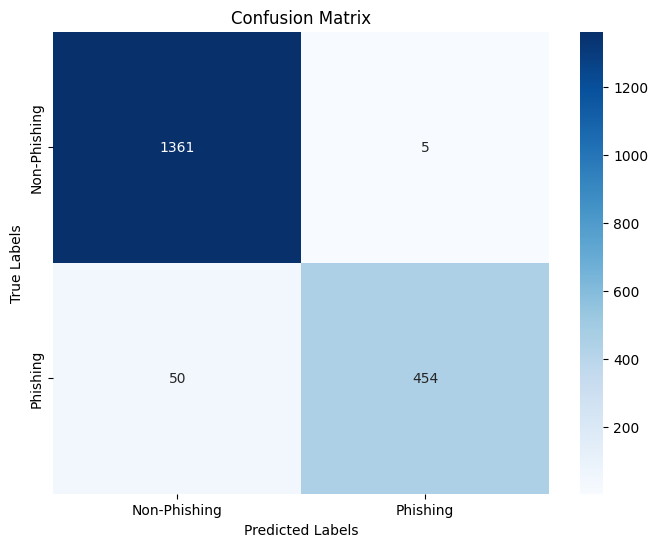

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, preds)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Phishing', 'Phishing'], yticklabels=['Non-Phishing', 'Phishing'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()